# Importing Modules


In [2]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
import random
import gym
import matplotlib.pyplot as plt


from itertools import product
from collections import deque
import optuna
import matplotlib.patches as mpatches




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#  Hyperparameter search and optimization

In [3]:
def train_agent(
    epsilon,
    decay, 
    lr, 
    weight_decay,
    arch,
    activation, 
    optimizer_type, 
    runs=10,
    episodes=250,
    
    ):    
    runs_results = []
    env = gym.make('CartPole-v1')
    
    batch_size = 25
    buffer_size = 20000
    update_iterations = 2

    for _ in range(runs):
        
        policy_net = DQN(arch, activation)
        target_net = DQN(arch, activation)
        update_target(target_net, policy_net)
        target_net.eval()
        epsilon = epsilon

        if optimizer_type == 'Adam':
            optimizer = optim.Adam(policy_net.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_type == 'RAdam':
            optimizer = optim.RAdam(policy_net.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_type == 'SGD':
            optimizer = optim.SGD(policy_net.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            return

        memory = ReplayBuffer(buffer_size)

        episode_durations = []

        for i_episode in range(episodes):

            observation, _ = env.reset()
            state = torch.tensor(observation).float()
            done = False
            terminated = False 
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                observation, reward, done, terminated, _ = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1

                if epsilon < 0.01:
                    epsilon = 0.01
                else:
                    epsilon = epsilon*decay
            # Update the target network, copying all weights and biases in DQN
            if i_episode % update_iterations == 0: 
                update_target(target_net, policy_net)
        
        runs_results.append(episode_durations)

    return runs_results

# 1. Define an objective function to be maximized.

def objective(trial):
    
    batch_size = 25
    buffer_size = 2000
    update_iterations = 2
    epsilon= trial.suggest_uniform("epsilon", 0, 1)  # epislon - action to take     
    decay = 0.99
    optimizer_type = trial.suggest_categorical('optimiser', ['Adam', 'RAdam', 'SGD'])
    lr = trial.suggest_loguniform("lr", 1e-3, 1)
    weight_decay = 0
    #neural network 
    arch = trial.suggest_categorical('policy_network_nn', [ 
        [4, 32, 2], [4, 64, 2], [4, 32, 32, 2],[4, 64, 32, 2],  [4, 64, 64, 2],[4, 64, 128, 2],  
        [4, 64, 64, 2],  [4, 128, 128, 2], [4, 32, 32, 32, 2], [4, 64, 64, 64, 2], 
        [4, 128, 128, 128, 2], 
    ])
    activation = trial.suggest_categorical('activation_function',[F.relu,  F.leaky_relu, F.sigmoid, F.tanh])

    runs_results = train_agent(
                        epsilon, 
                        decay,
                        lr, 
                        weight_decay,
                        arch, 
                        activation, 
                        optimizer_type
                    )
    
    final_value = objective_evaluation(runs_results)

    if final_value < 0:
        good_parameters = [epsilon, 
                    decay,
                    lr, 
                    weight_decay,
                    arch,                         
                    activation, 
                    optimizer_type]
        print(final_value, good_parameters)
    
    return final_value

def objective_evaluation(runs_results):
    means = torch.tensor(runs_results).float().mean(0)
    return (len(means.detach().numpy()) - np.count_nonzero(means.detach().numpy()>100))


study = optuna.create_study(study_name="cartpole")
study.optimize(objective, n_trials=1)  
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
 print("{}: {}".format(key, value))


     


[I 2023-11-18 16:50:53,477] A new study created in memory with name: cartpole
/var/folders/k1/5z41w6_s3fb9r4hv06t6568h0000gn/T/ipykernel_67003/969174340.py:97: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon= trial.suggest_uniform("epsilon", 0, 1)  # epislon - action to take
/var/folders/k1/5z41w6_s3fb9r4hv06t6568h0000gn/T/ipykernel_67003/969174340.py:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-3, 1)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but co

Best trial:
Value:  250.0
Params: 
epsilon: 0.43719921580683196
optimiser: RAdam
lr: 0.002810231022579435
policy_network_nn: [4, 64, 2]
activation_function: <function sigmoid at 0x7f9321e62430>


In [ ]:
''' OBTAINED FROM OPTUNA STUDY

epsilon = 0.8
decay = 0.99
lr = 0.001
optimizer_type = Adam
weight_decay = 0 
activation = F.leakyrelu
arch = [4, 128, 64, 2]

Fixed Values used for training DQN Agent
batch_size = 25
buffer_size = 2000
iterations = 2   '''


# Question 1 - Train the DQN and print Learning Curve

In [82]:
def train_dqn_agent(
    epsilon,
    decay, 
    lr, 
    weight_decay,  
    arch, 
    activation, 
    optimizer_type, 
    runs=10,
    episodes=300,
    
    ):    
    runs_results = []
    env = gym.make('CartPole-v1')
    
    batch_size = 25
    buffer_size = 20000
    update_iterations = 2
    
    for _ in range(runs):
        
        policy_net = DQN(arch, activation)
        target_net = DQN(arch, activation)
        update_target(target_net, policy_net)
        target_net.eval()
        epsilon = epsilon

        if optimizer_type == 'Adam':
            optimizer = optim.Adam(policy_net.parameters(), lr=lr, weight_decay=weight_decay)
        elif  optimizer_type == 'SGD':
            optimizer = optim.SGD(policy_net.parameters(), lr=lr, weight_decay=weight_decay)
        elif  optimizer_type == 'RAdam':
            optimizer = optim.RAdam(policy_net.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            return

        memory = ReplayBuffer(buffer_size)

        episode_durations = []

        for i_episode in range(episodes):

            observation, _ = env.reset()
            state = torch.tensor(observation).float()
            done = False
            terminated = False 
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                observation, reward, done, terminated, _ = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1

                if epsilon < 0.01:
                    epsilon = 0.01
                else:
                    epsilon = epsilon*decay
            # Update the target network, copying all weights and biases in DQN
            if i_episode % update_iterations == 0: 
                update_target(target_net, policy_net)
        
        runs_results.append(episode_durations)

    return runs_results

In [83]:
# chage episodes to 300 to print for cw
unoptimized_results = train_dqn_agent(
                        epsilon=1,
                        decay=1, 
                        lr=1, 
                        weight_decay=0, 
                        arch=[4,2],  
                        activation=F.relu, 
                        optimizer_type='SGD', 
                        runs=10,
                        episodes=300
                    )

optimized_results = train_dqn_agent(
                        epsilon=0.8,
                        decay=0.99, 
                        lr=0.001, 
                        weight_decay=0, 
                        arch=[4, 128, 64, 2], 
                        activation=F.leaky_relu, 
                        optimizer_type='Adam', 
                        runs=10,
                        episodes=300
                    )

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


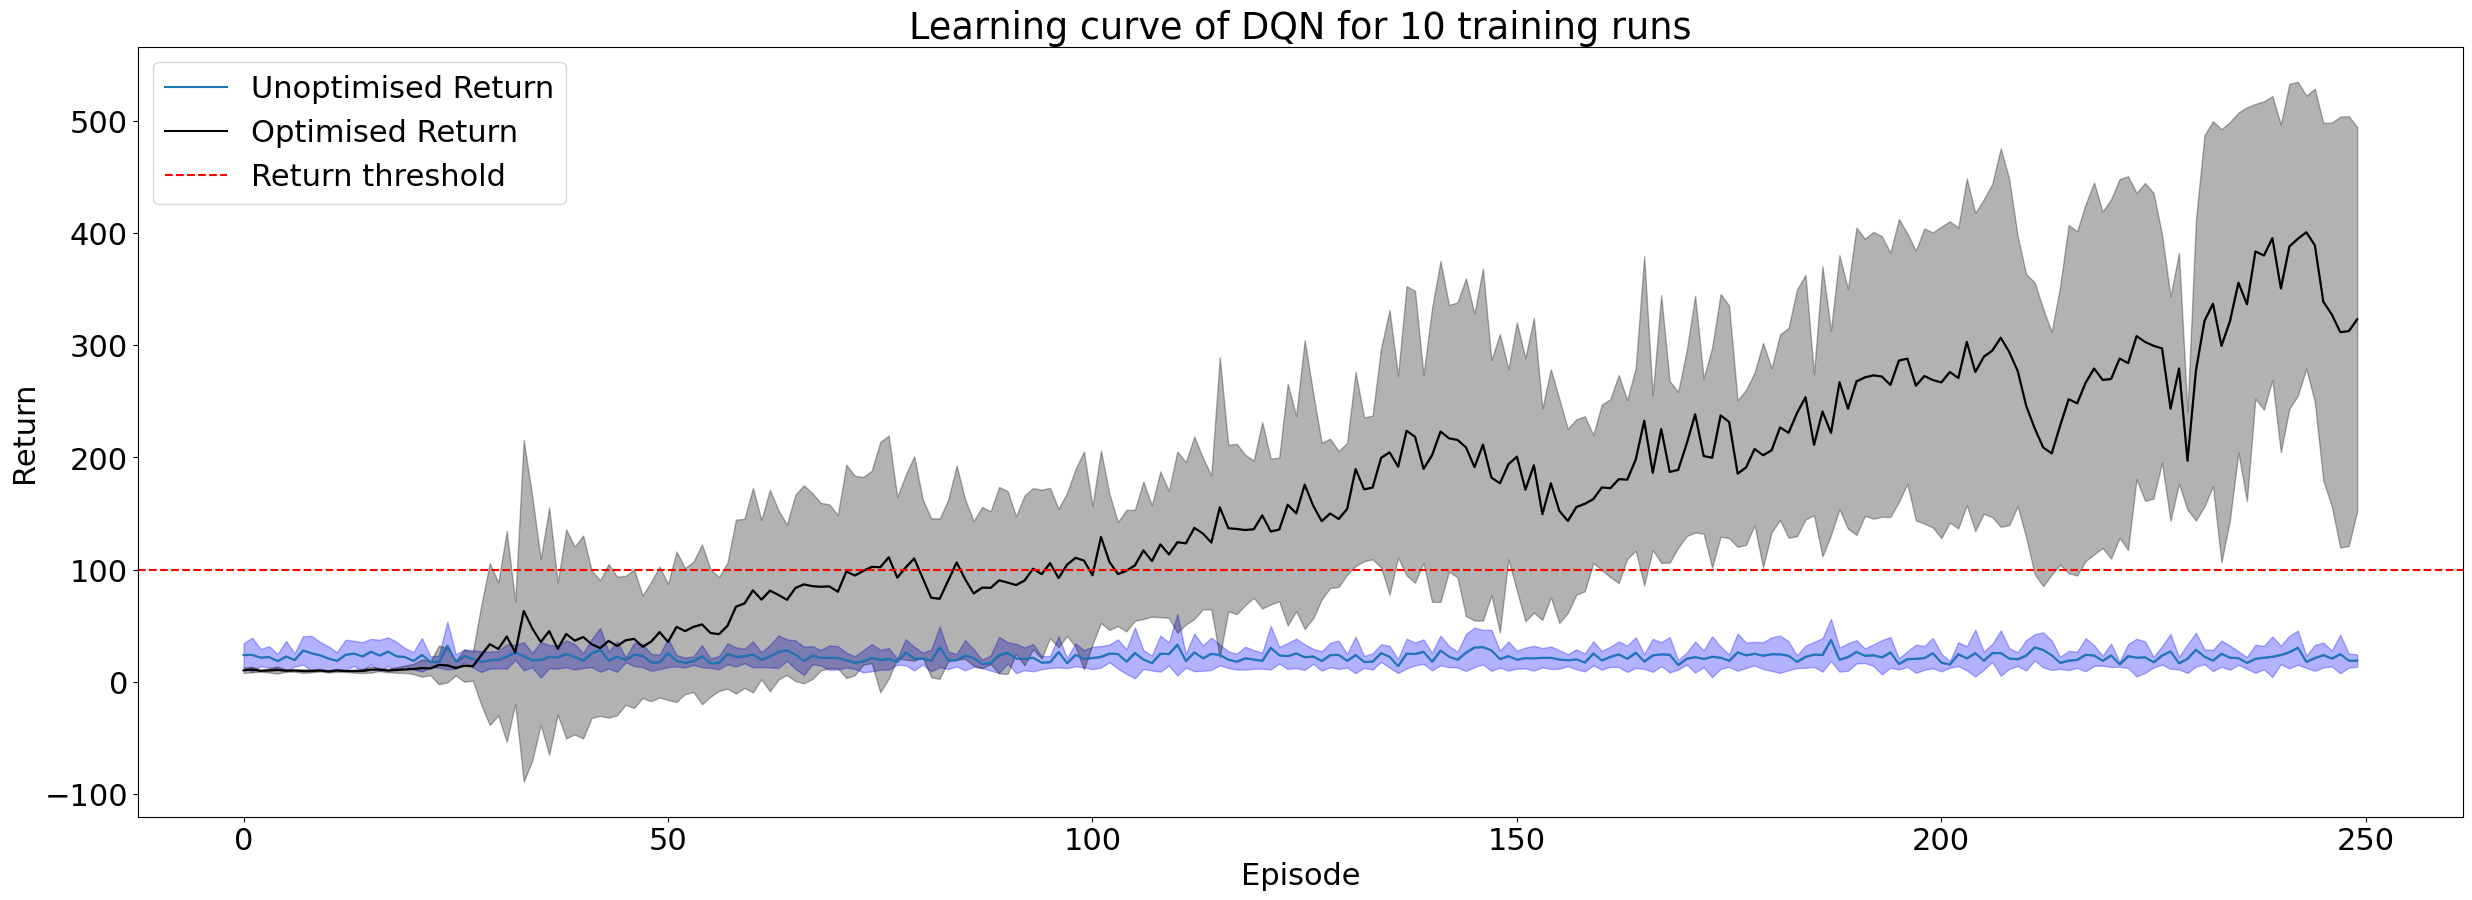

In [76]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})

means_unoptimized = torch.tensor(unoptimized_results).float().mean(0)
stds_unoptimized = torch.tensor(unoptimized_results).float().std(0)


means_optimized = torch.tensor(optimized_results).float().mean(0)
stds_optimized = torch.tensor(optimized_results).float().std(0)

plt.plot(torch.arange(300), means_unoptimized, label="Unoptimised Return")
plt.fill_between(np.arange(300), means_unoptimized, means_unoptimized+stds_unoptimized, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means_unoptimized, means_unoptimized-stds_unoptimized, alpha=0.3, color='b')

plt.plot(torch.arange(300), means_optimized, label="Optimised Return",color= "k")
plt.fill_between(np.arange(300), means_optimized, means_optimized+stds_optimized, alpha=0.3, color='k')
plt.fill_between(np.arange(300), means_optimized, means_optimized-stds_optimized, alpha=0.3, color='k')

plt.ylabel("Return")
plt.xlabel("Episode")
plt.title("Learning curve of DQN for 10 training runs")
plt.axhline(y = 100, color = 'r', linestyle = '--',label= "Return threshold")
plt.legend(loc='upper left')
plt.show()

# Question 2 - Print the graphs of Greedy policy action and Q values


In [1]:
def train_dqn_agent(
    epsilon,
    decay, 
    lr, 
    weight_decay,  
    arch, 
    activation, 
    optimizer_type, 
    runs=10,
    episodes=250,
    
    ):    
    runs_results = []
    env = gym.make('CartPole-v1')
    
    batch_size = 25
    buffer_size = 20000
    update_iterations =2
    
    for _ in range(runs):
        
        policy_net = DQN(arch, activation)
        target_net = DQN(arch, activation)
        update_target(target_net, policy_net)
        target_net.eval()
        epsilon = epsilon

        if optimizer_type == 'Adam':
            optimizer = optim.Adam(policy_net.parameters(), lr=lr, weight_decay=weight_decay)
        elif  optimizer_type == 'SGD':
            optimizer = optim.SGD(policy_net.parameters(), lr=lr, weight_decay=weight_decay)
        elif  optimizer_type == 'RAdam':
            optimizer = optim.RAdam(policy_net.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            return

        memory = ReplayBuffer(buffer_size)

        episode_durations = []

        for i_episode in range(episodes):

            observation, _ = env.reset()
            state = torch.tensor(observation).float()
            done = False
            terminated = False 
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                observation, reward, done, terminated, _ = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1

                if epsilon < 0.01:
                    epsilon = 0.01
                else:
                    epsilon = epsilon*decay
            # Update the target network, copying all weights and biases in DQN
            if i_episode % update_iterations == 0: 
                update_target(target_net, policy_net)
        
        runs_results.append(episode_durations)

    return policy_net

In [78]:

optimized_dqn = train_dqn_agent(
                        epsilon=0.8,
                        decay=0.99, 
                        lr=0.001, 
                        weight_decay=0, 
                        arch=[4, 128, 64, 2], 
                        activation=F.leaky_relu, 
                        optimizer_type='Adam', 
                        runs=1,
                        episodes=250)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [59]:
def visualize_policy_q(policy_net, visualize_q ,speed, title):
    plt.figure(figsize=(30, 10))
    plt.rcParams.update({'font.size': 12})

    angle_range = 0.2094  # 12 degrees in cart-pole environment
    omega_range = 2     # You may modify this range

    angle_samples = 200
    omega_samples = 200
    angles = torch.linspace(angle_range, -angle_range, angle_samples)
    omegas = torch.linspace(-omega_range, omega_range, omega_samples)

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))

    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., speed, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action

    if visualize_q:
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
        plt.colorbar()
    else:
        plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
        yellow_patch = mpatches.Patch(color='yellow', label='1 - Push to the right')
        blue_patch = mpatches.Patch(color='blue', label='0 - Push to the left')
        plt.legend(handles=[yellow_patch, blue_patch])

    plt.xlabel(" Pole Angle [radians] ")
    plt.ylabel(" Pole Angular Velocity [radians/second]")
    plt.title(title)
    plt.show()

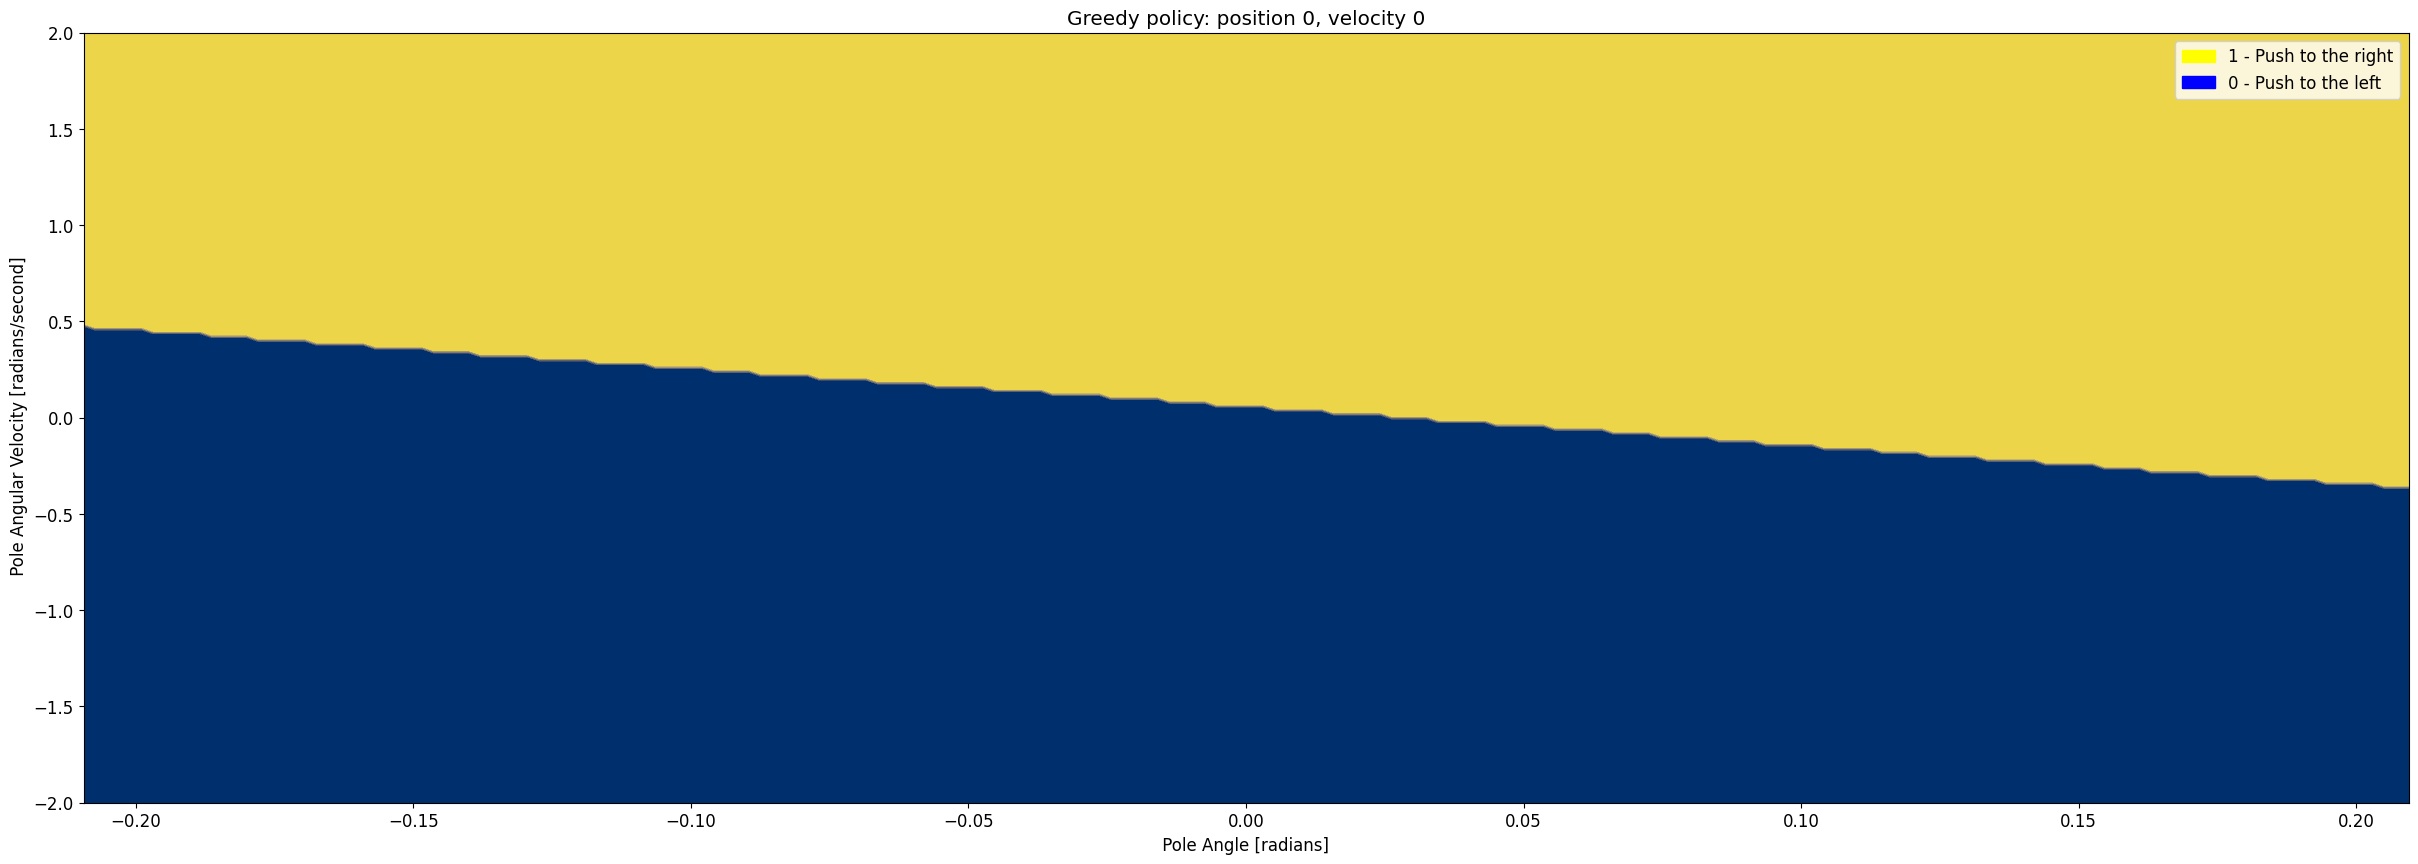

'visualize_policy_q(policy_dqn, speed=0.5, visualize_q=False, title="Greedy policy: position 0, velocity 0.5")\nvisualize_policy_q(policy_dqn, speed=1, visualize_q=False, title="Greedy policy: position 0, velocity 1")\nvisualize_policy_q(policy_dqn, speed=2, visualize_q=False, title="Greedy policy: position 0, velocity 2")'

In [63]:
visualize_policy_q(optimized_dqn, speed=0, visualize_q=False, title="Greedy policy: position 0, velocity 0")

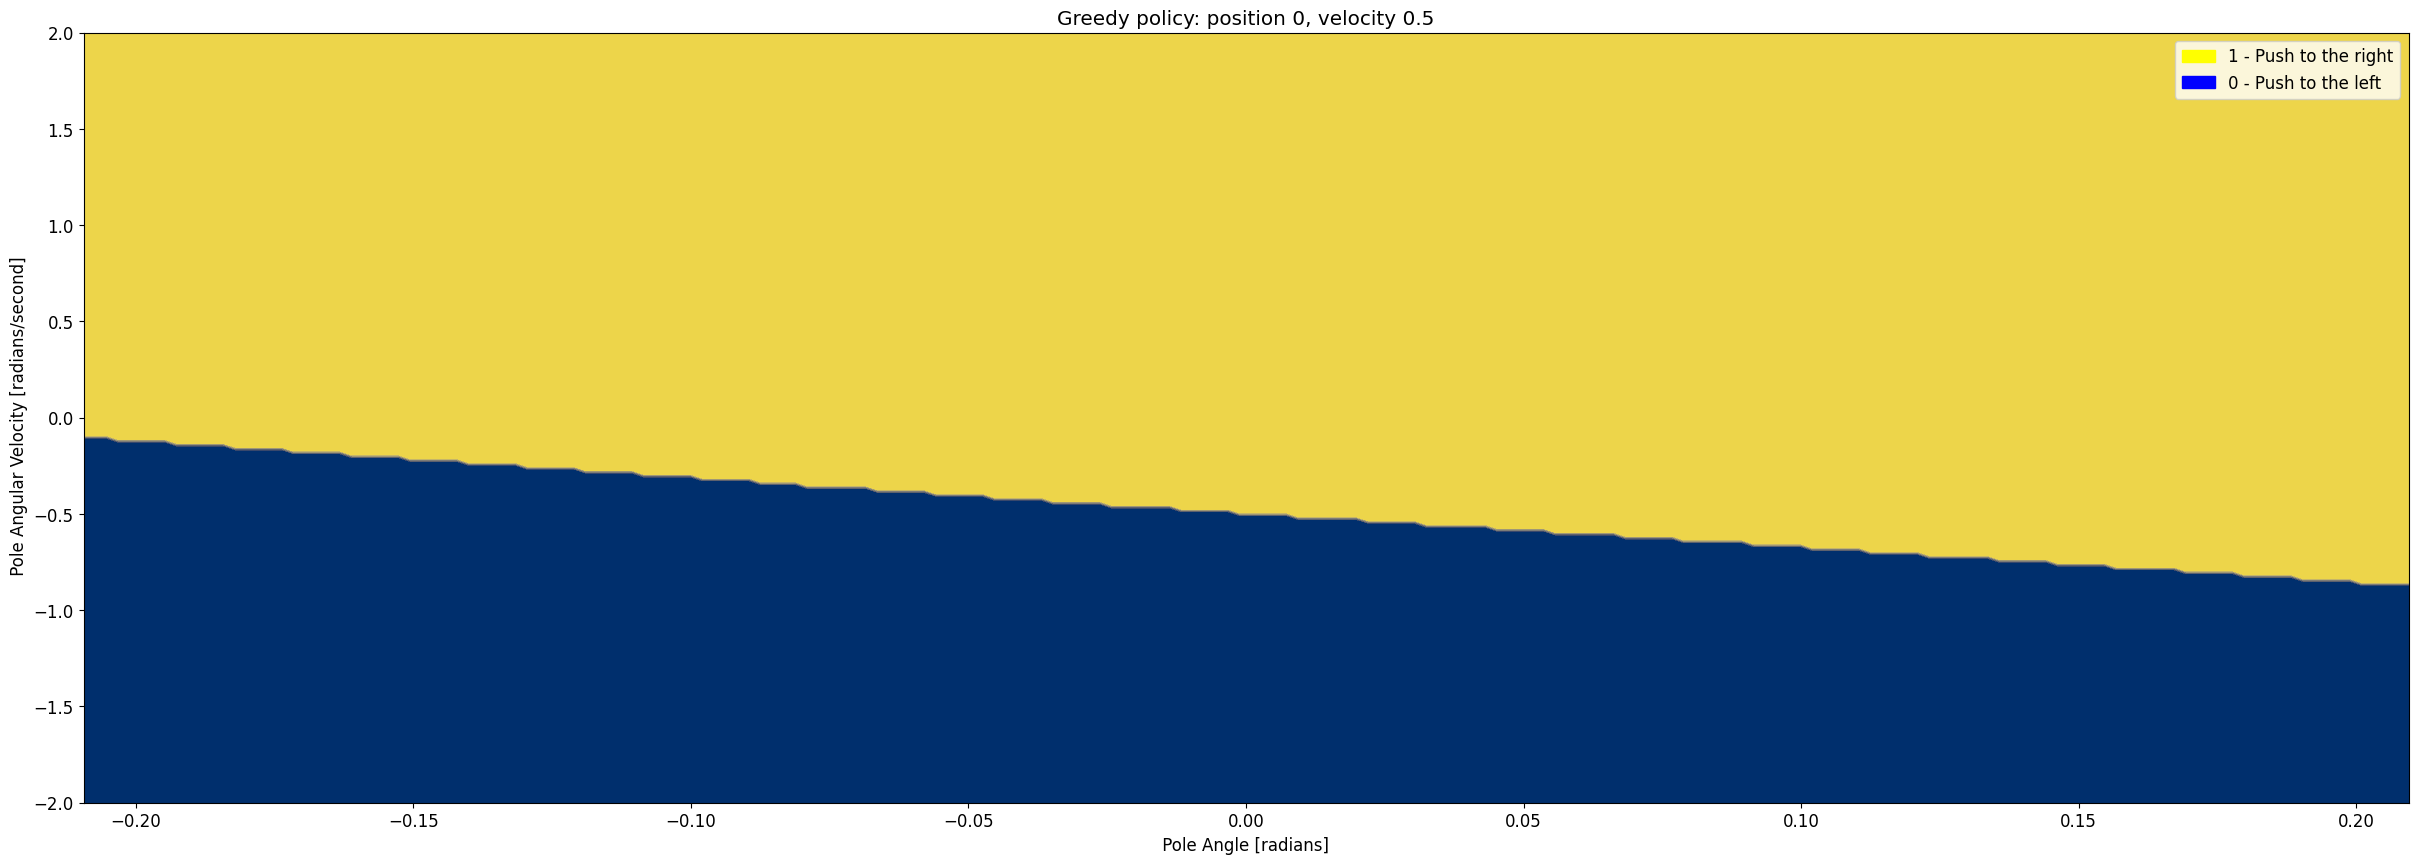

In [64]:
visualize_policy_q(optimized_dqn , speed=0.5, visualize_q=False, title="Greedy policy: position 0, velocity 0.5")


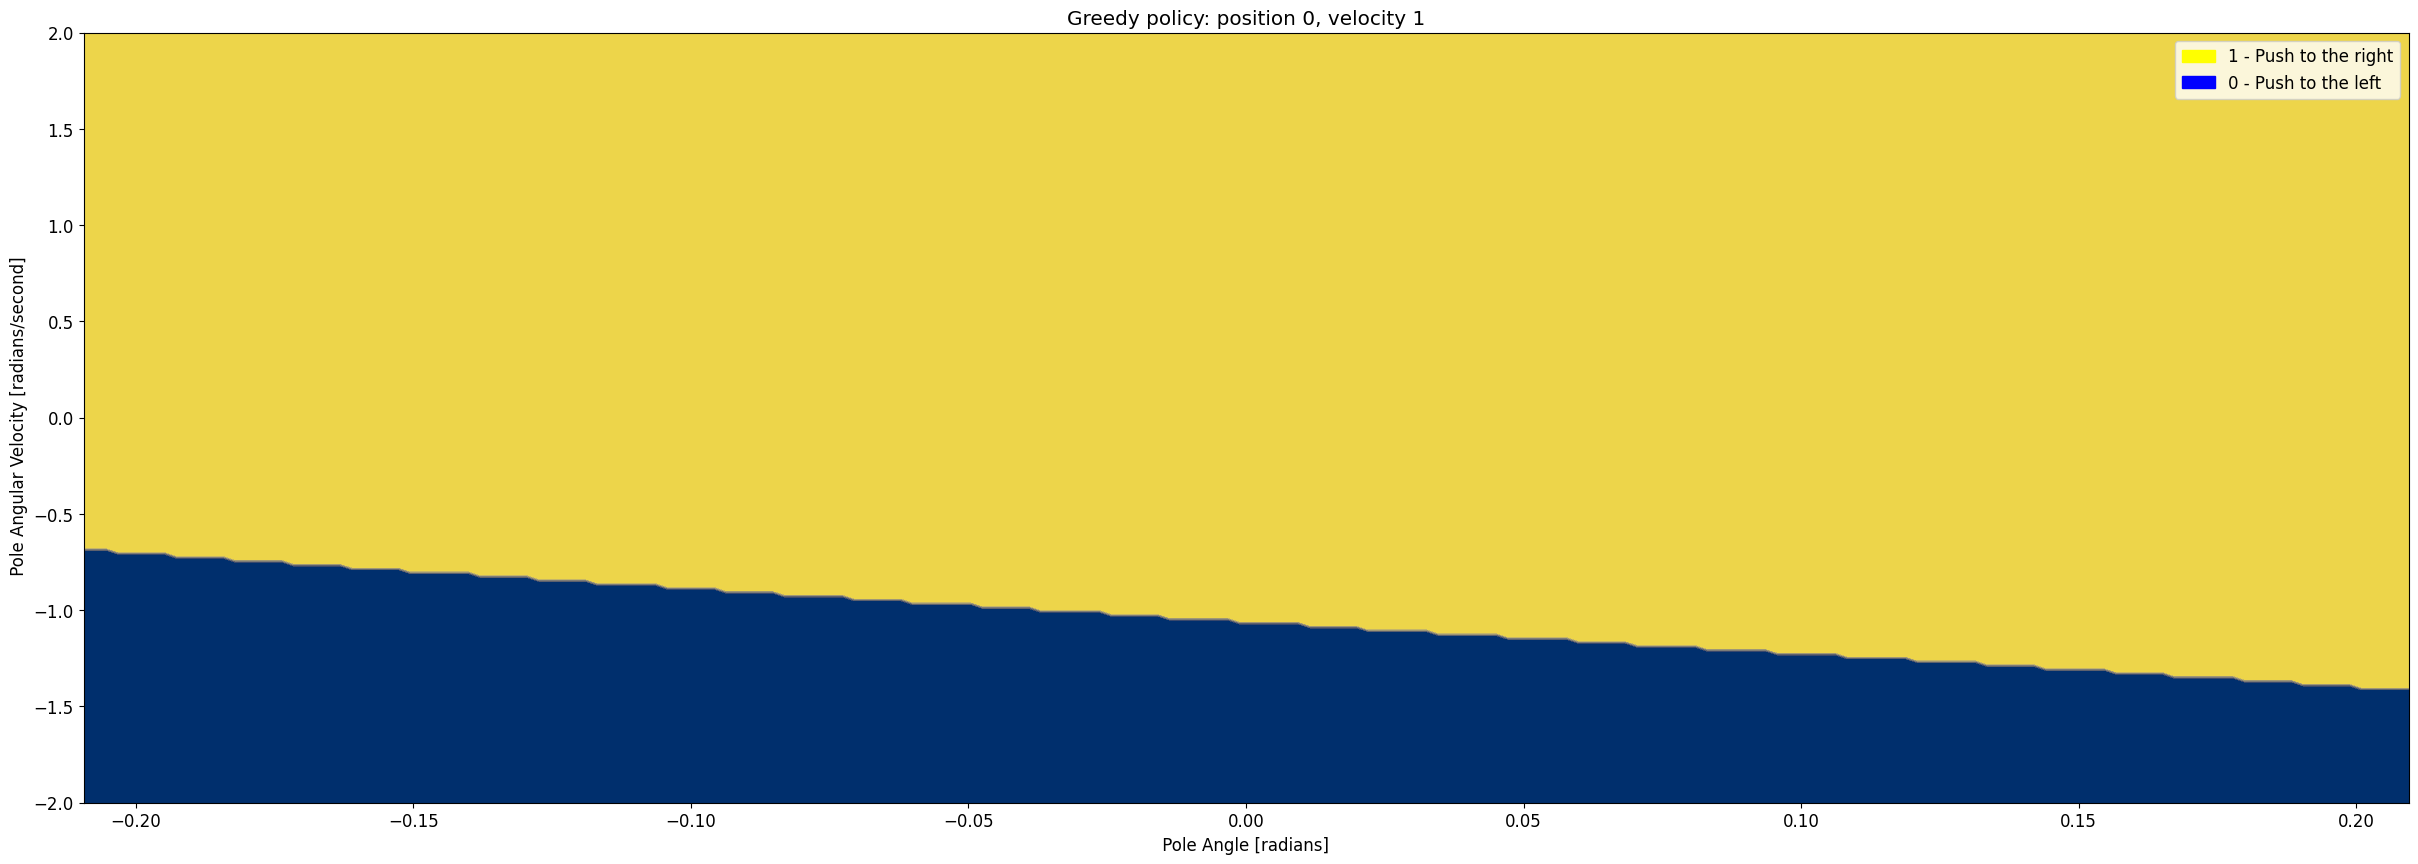

In [65]:
visualize_policy_q(optimized_dqn , speed=1, visualize_q=False, title="Greedy policy: position 0, velocity 1")

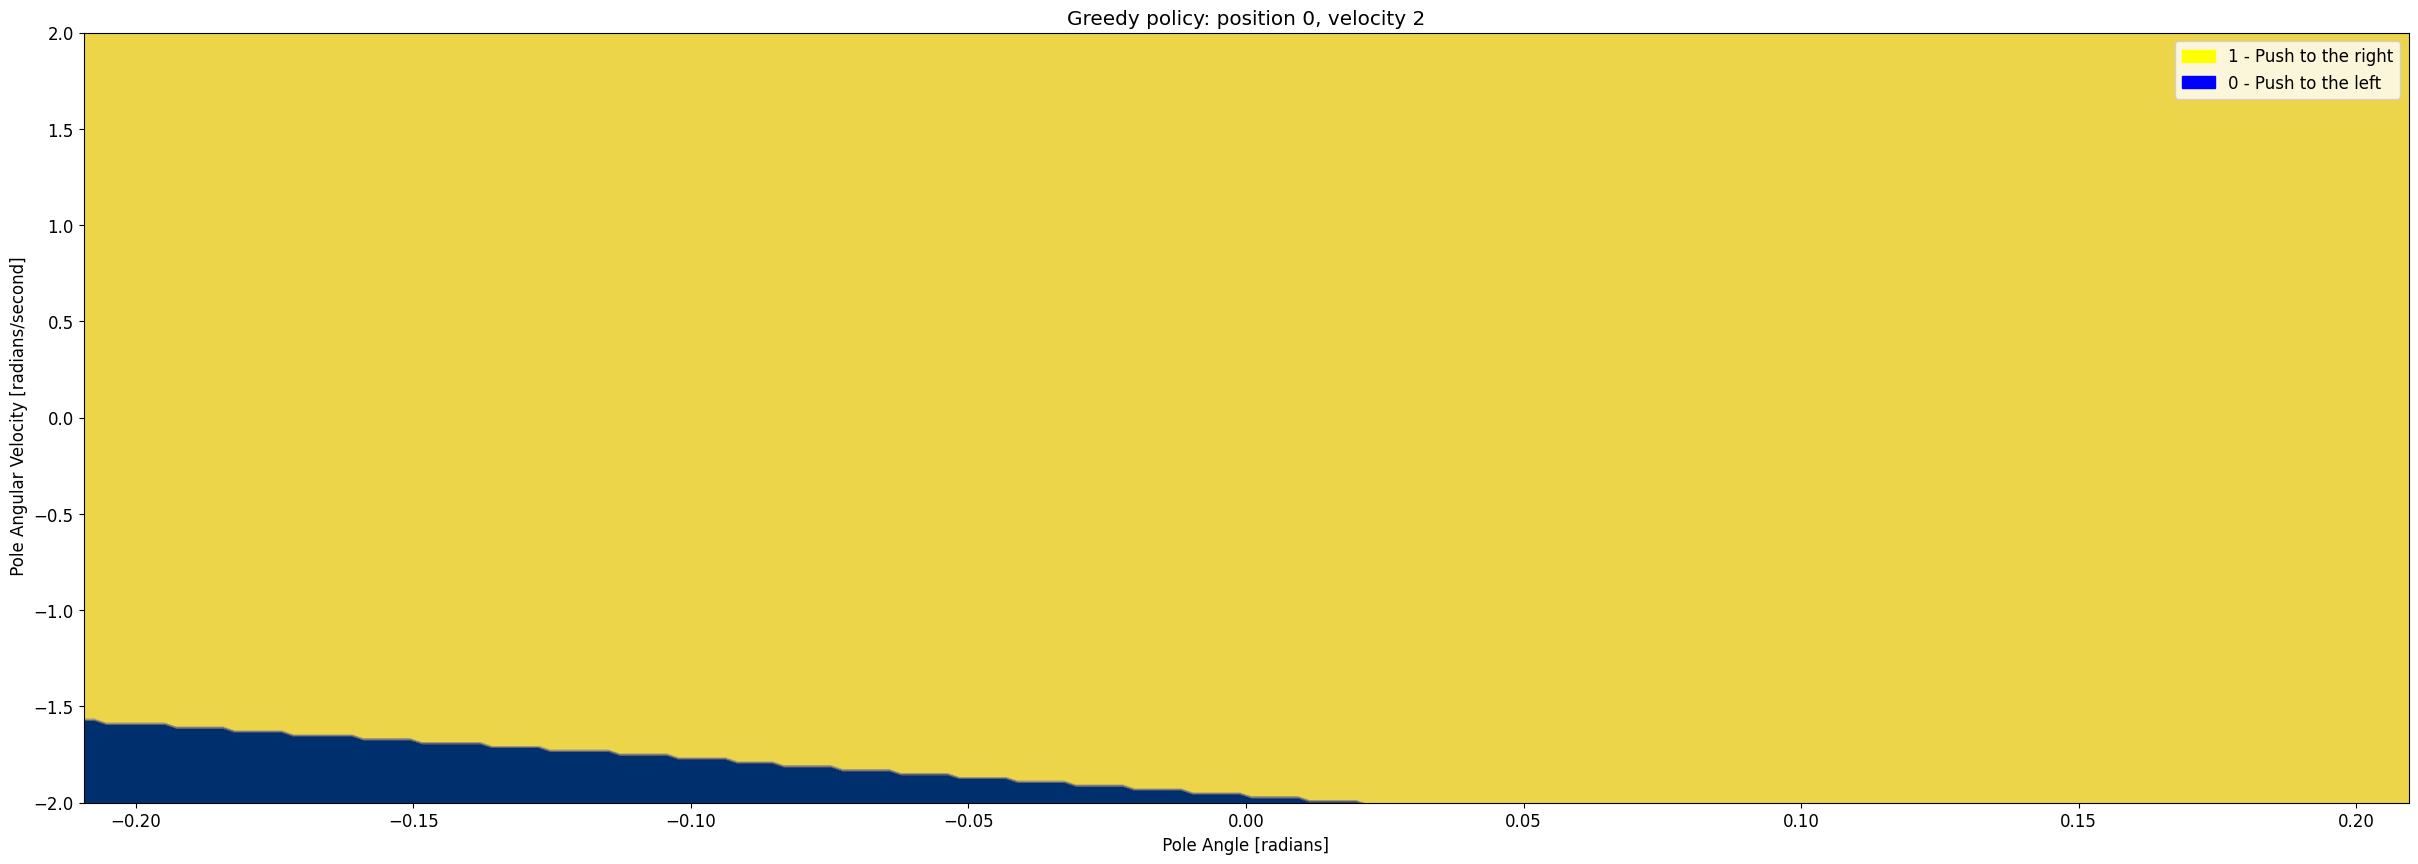

In [66]:
visualize_policy_q(optimized_dqn , speed=2, visualize_q=False, title="Greedy policy: position 0, velocity 2")

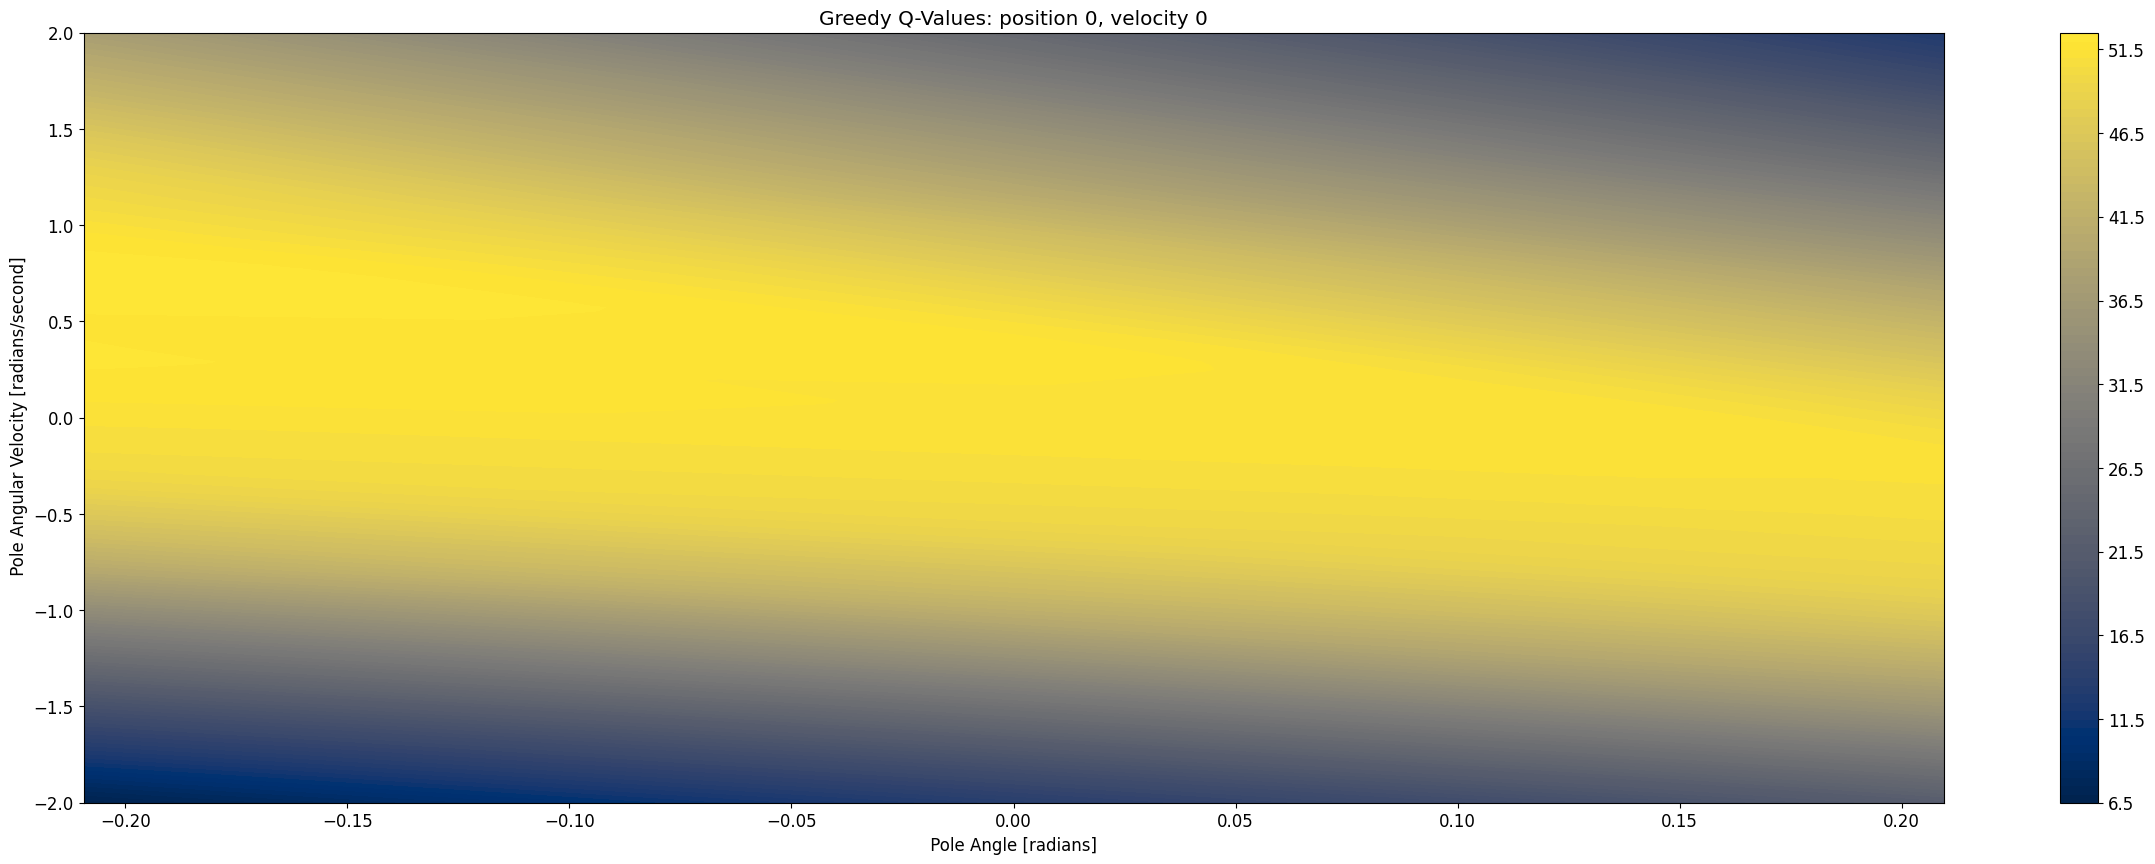

In [67]:
visualize_policy_q(optimized_dqn, speed=0, visualize_q=True, title="Greedy Q-Values: position 0, velocity 0")


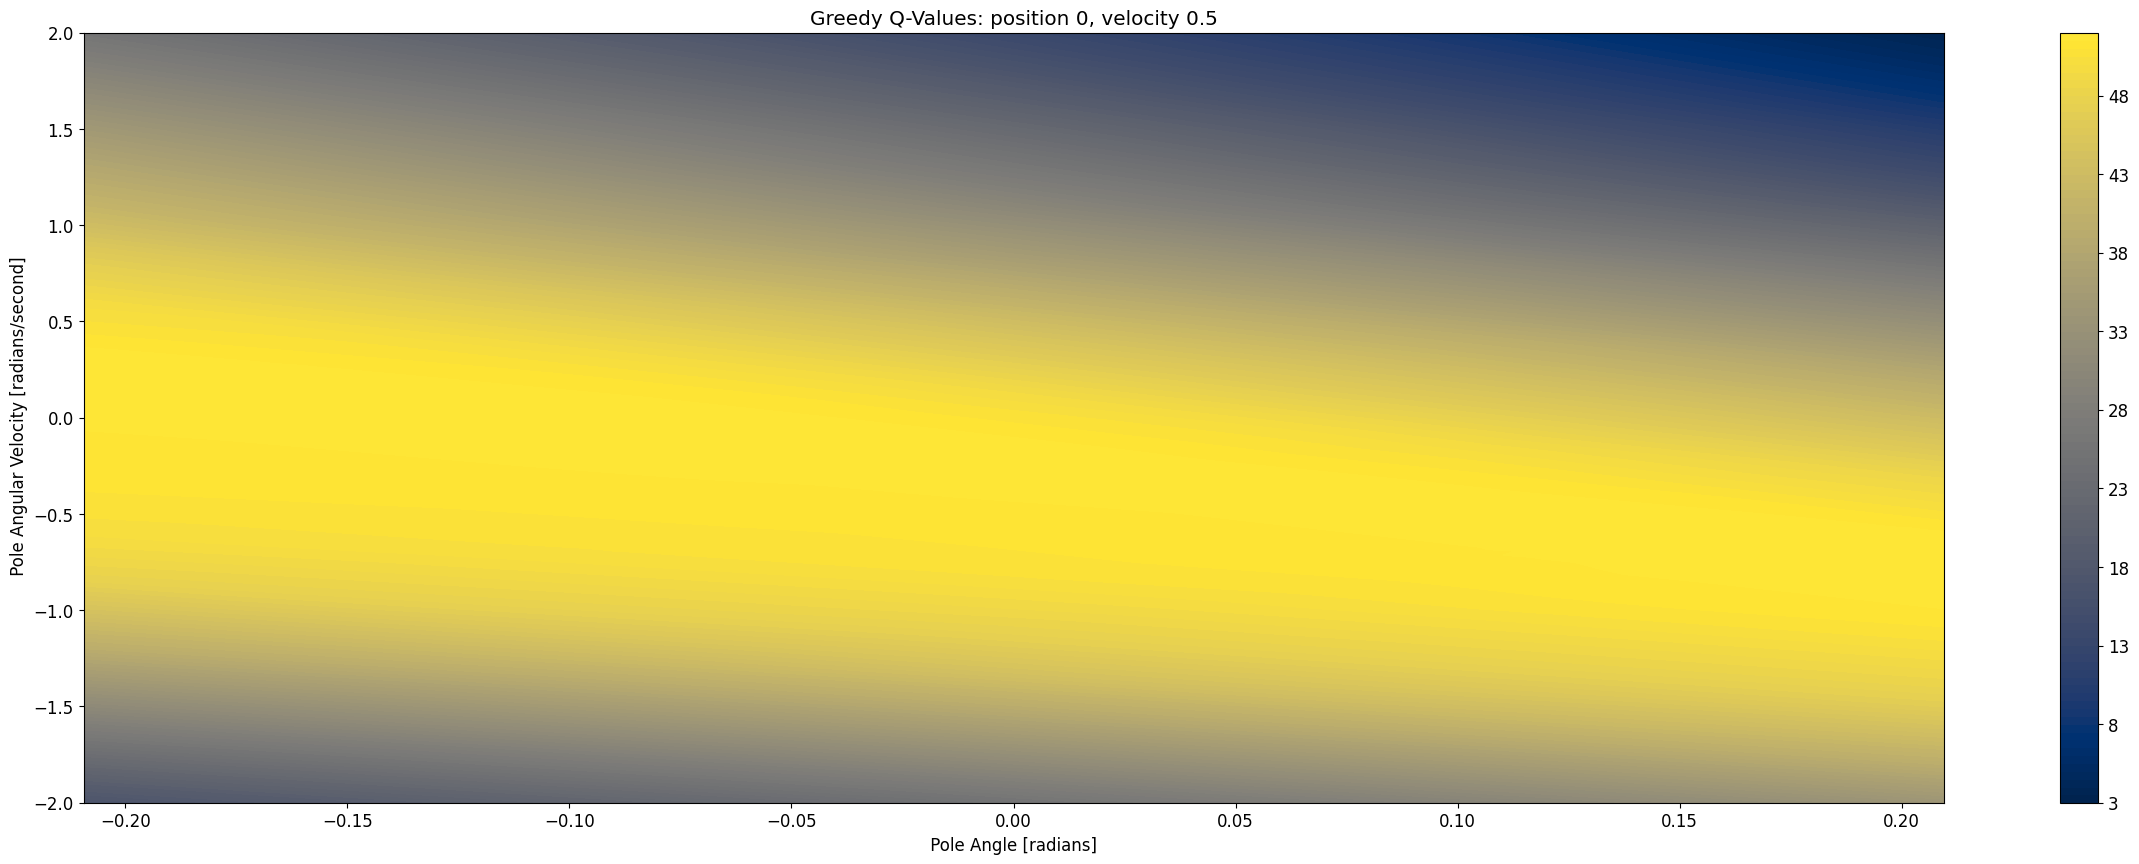

In [68]:
visualize_policy_q(optimized_dqn, speed=0.5, visualize_q=True, title="Greedy Q-Values: position 0, velocity 0.5")

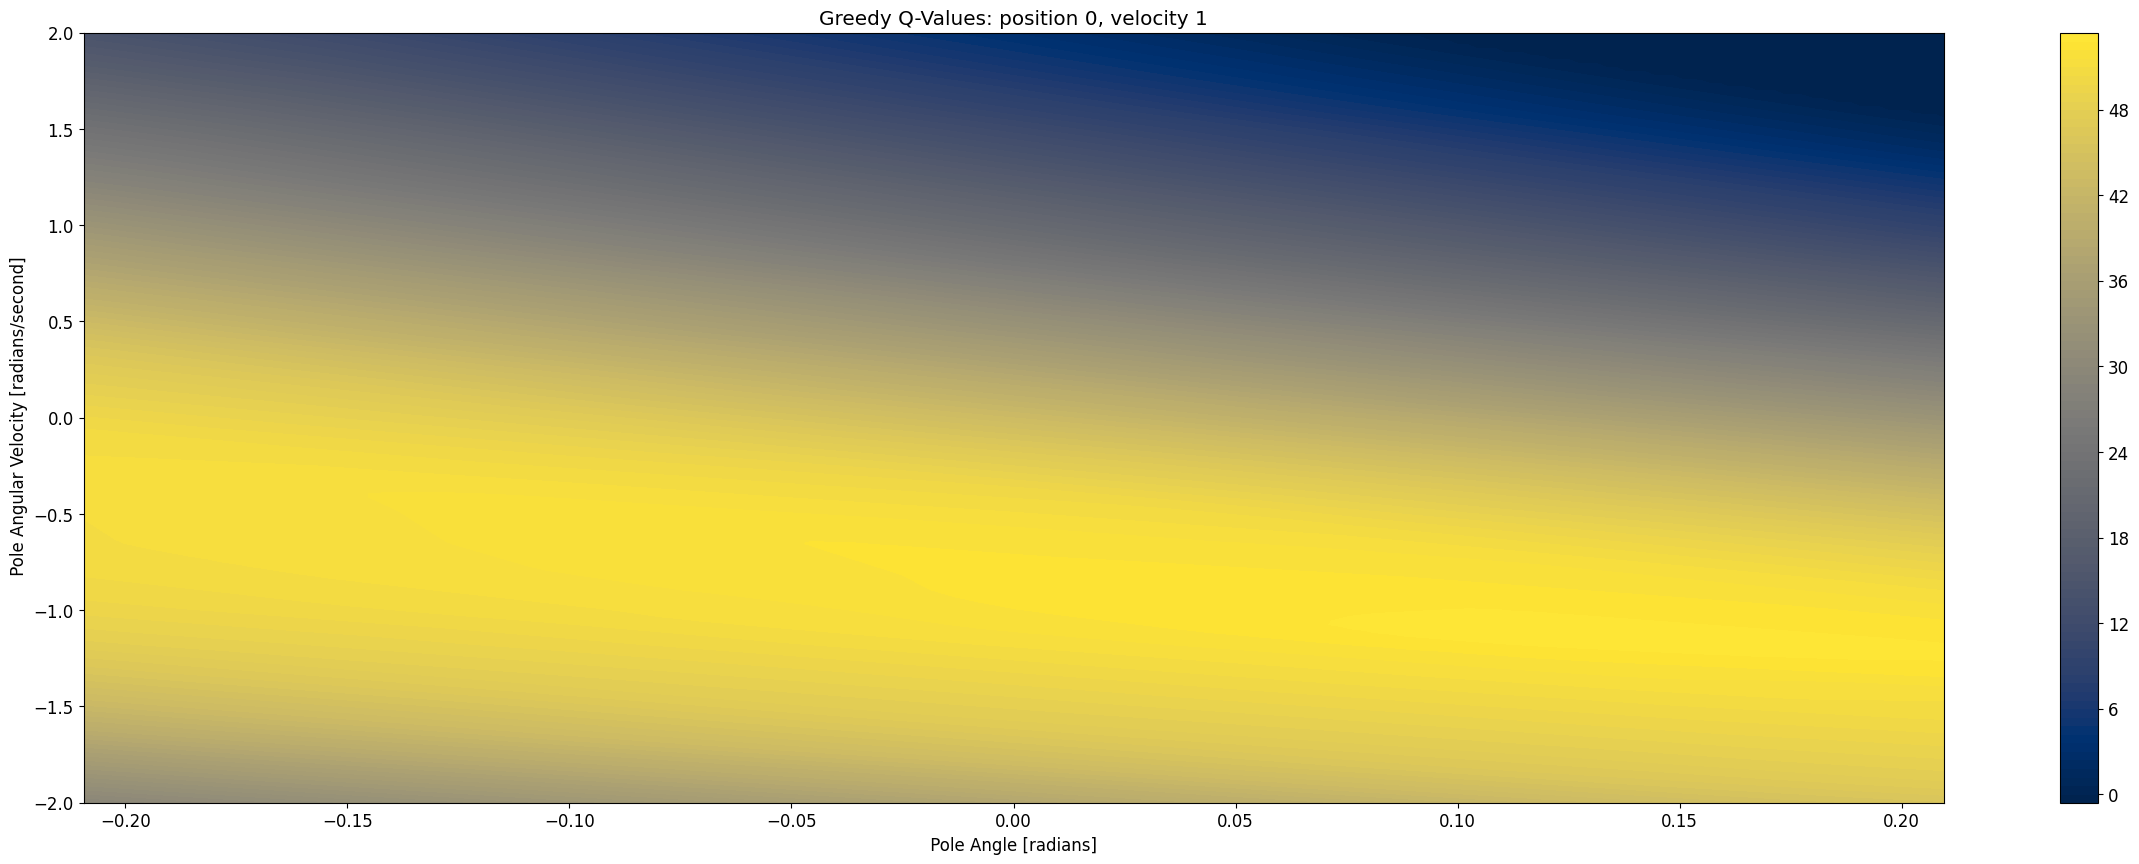

In [69]:
visualize_policy_q(optimized_dqn, speed=1, visualize_q=True, title="Greedy Q-Values: position 0, velocity 1")

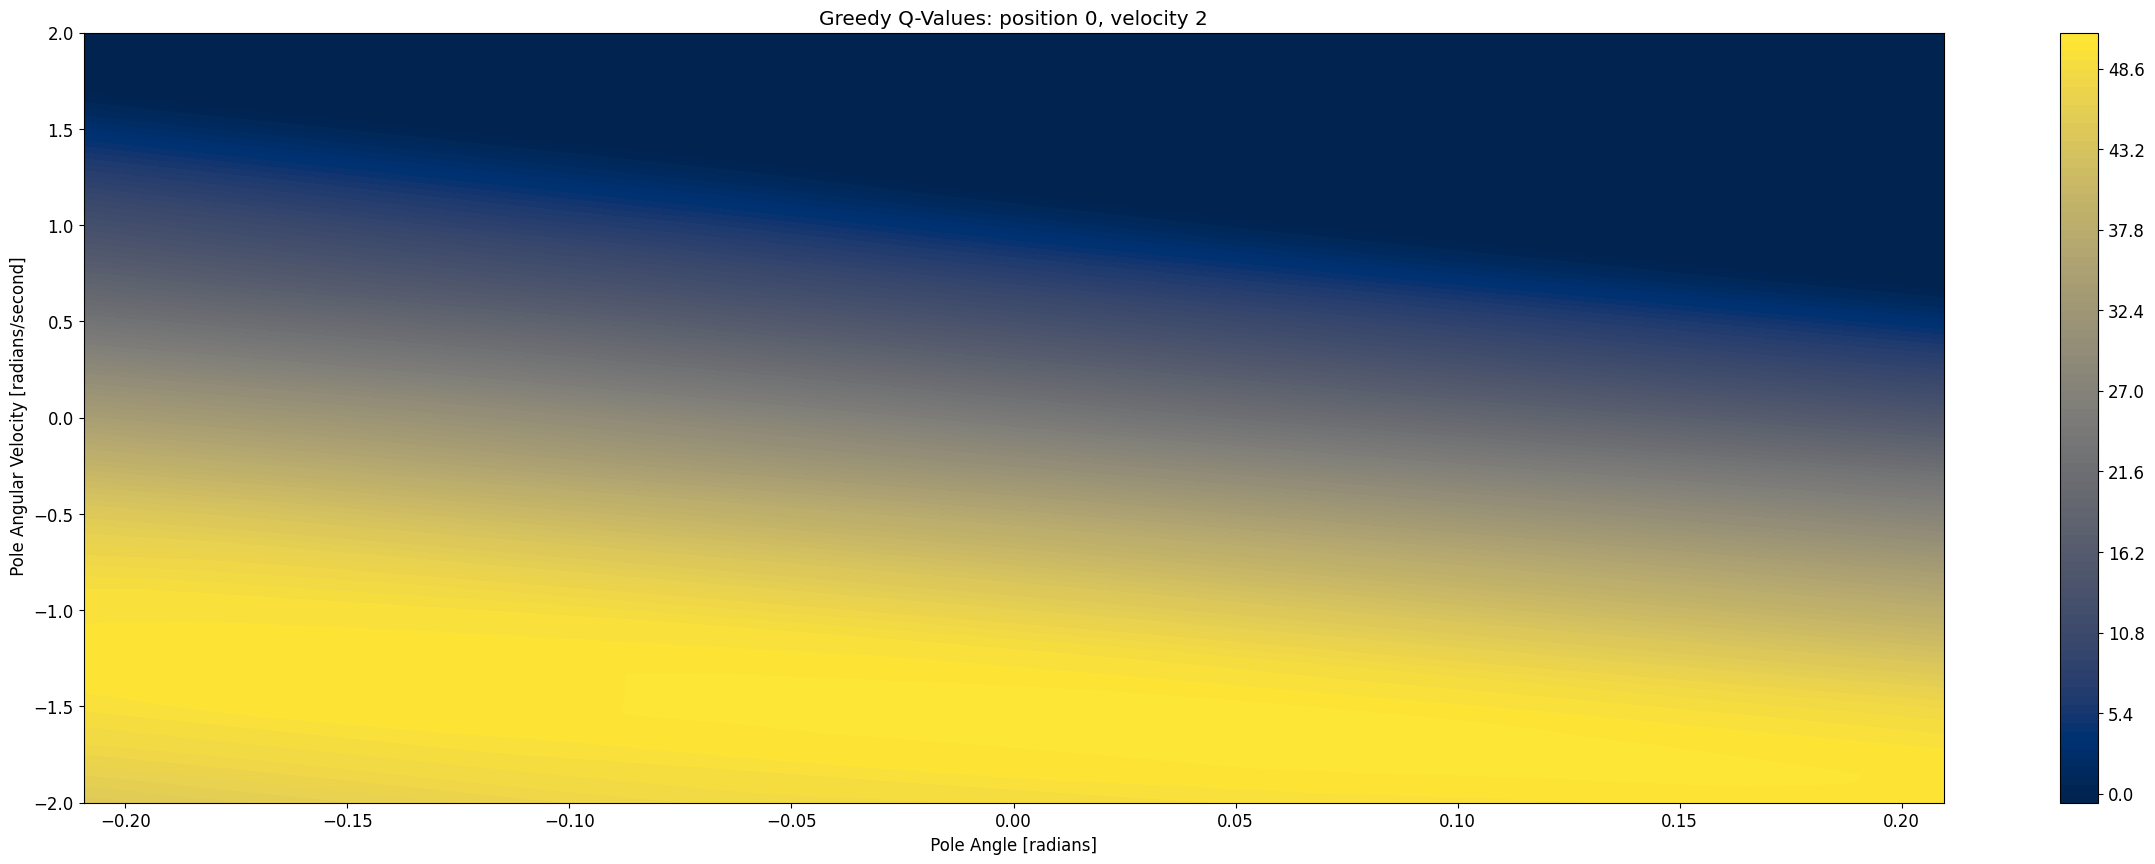

In [70]:
visualize_policy_q(optimized_dqn, speed=2, visualize_q=True, title="Greedy Q-Values: position 0, velocity 2")